In [148]:
import pandas as pd
import numpy as np
import sys, os , warnings
import pandas_profiling
from sklearn.preprocessing import LabelEncoder, StandardScaler ,MinMaxScaler,RobustScaler, PowerTransformer, normalize

import pandas as pd
import numpy as np
import pandas_profiling, pickle
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import StandardScaler, RobustScaler,power_transform
from scipy.stats import skew

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score





from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [150]:
warnings.filterwarnings('ignore')



def get_data():
    """
    Retrive Train and Test data
    """

    train = pd.read_csv("/content/drive/MyDrive/half_gan_work/vanilla/DOS_Preprocesstain.csv")
    test = pd.read_csv("/content/drive/MyDrive/half_gan_work/vanilla/DOS_Preprocesstest (1).csv")
    return train, test

In [151]:
 x_train,x_test= get_data()

In [152]:
x_train.drop(["Unnamed: 0"],axis=1,inplace=True)
x_train

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,attack
0,-0.261670,0.532692,0.272187,0.042320,-0.373792,-0.237265,-0.484287,-0.051673,-0.120477,-0.076283,-0.158055,-0.130387,0.063966,0.018481,normal
1,0.218320,1.016720,0.135702,0.066672,-0.784205,-0.072116,0.305359,0.364307,0.247091,-0.309637,0.450536,0.059455,0.348620,0.089028,normal
2,1.736280,-0.353912,0.004664,-0.015347,0.023537,-0.062147,0.138908,-0.036646,-0.063753,-0.077040,0.011873,-0.021056,0.004402,0.026085,neptune
3,-1.009131,-0.607467,0.119472,-0.241722,0.284433,-0.068508,0.021614,0.122778,0.057927,0.099407,-0.007952,-0.080227,0.056512,0.009813,normal
4,-0.999657,-0.411611,-0.491055,0.113412,-0.069412,0.181505,0.066167,-0.129151,0.050811,-0.053955,-0.028073,0.055005,-0.027095,0.021337,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113265,1.719373,-0.351974,0.011388,0.022741,0.011383,-0.031595,0.121942,-0.034803,-0.100215,0.039877,-0.001858,0.010614,-0.011460,-0.008832,neptune
113266,-0.662704,0.042510,-0.301710,0.699522,-0.101131,-0.573907,0.268304,-0.006005,-0.159208,-0.144221,-0.022740,0.026763,0.011520,0.068593,normal
113267,-0.163481,-0.028645,-0.366157,-0.580721,-0.692718,-0.026171,-0.096540,-0.273273,-0.181930,0.094145,-0.049342,0.018857,-0.056450,-0.081481,normal
113268,1.759930,-0.328508,0.037398,0.018116,0.016805,0.024234,-0.096033,-0.026090,0.078582,-0.054377,0.028381,-0.018086,0.013996,0.015820,neptune


In [153]:

y_train = x_train.attack.values
y_test = x_test.attack.values

In [154]:
data_cols = list(x_train.columns[ x_train.columns != 'attack' ])

In [155]:
def create_discriminator(data_dim, min_num_neurones):
    model = tf.keras.models.Sequential(name='Discriminator')
    
    model.add(Dense(min_num_neurones*2, activation='relu',input_dim = data_dim ))
    model.add(Dense(min_num_neurones, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer="sgd")
    
    return model

In [156]:
def create_generator(data_dim, min_num_neurones,noise_dim):
    
    model = tf.keras.models.Sequential(name='Generator')
    
    model.add(Dense(min_num_neurones, activation='relu',input_dim = noise_dim ))
    model.add(Dense(min_num_neurones*2, activation='relu'))
    model.add(Dense(min_num_neurones*4, activation='tanh'))
    
    model.add(Dense(data_dim))
    
    model.compile(loss='binary_crossentropy', optimizer="sgd")
    
    return model

In [157]:
def create_gan(discriminator, generator, z_dim):
    discriminator.trainable=False
    gan_input = Input(shape=(z_dim,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    
    #gan_output = discriminator(generator(gan_input))
    gan= Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='sgd')
    return gan

In [158]:
def get_batch(X, batch_size=1):
    """
    Parameters:
    -----------
    X : ndarray
        The input data to sample a into batch
    size : int (default = 1)
        Batch size

    Return Value: ndarray - random choice of samples from the input X of batch_size
    """
    batch_ix = np.random.choice(len(X), batch_size, replace=False)
    return X[batch_ix]

In [159]:
def modelAccuracy(gen_pred,real_pred):
    """calculates the discriminator's accuracy on real and generated samples
    :param gen_pred : predictions for generated samples
    :type gen_pred : ndarray (numpy)
    :param real_pred : predictions for real samples
    :type real_pred : ndarray (numpy)
    :return : accuracy_on_generated , accuracy_on_generated
    :rtype : float
    """
    gen_pred = np.array([1.0 if i > 0.5 else 0.0 for i in gen_pred])
    gen_true = np.zeros(len(gen_pred))

    real_pred = np.array([1.0 if i > 0.5 else 0.0 for i in real_pred])
    real_true = np.ones(len(gen_pred))

    print('Discriminator accuracy on Fake : {}, Real : {}'.format(accuracy_score(gen_pred,gen_true),accuracy_score(real_pred,real_true)))
    return accuracy_score(gen_pred,gen_true)*100, accuracy_score(real_pred,real_true)*100

In [160]:

combined_loss, disc_loss_generated, disc_loss_real = [], [], []
generator=0
    
def training(arguments,X):
    global generator
    [rand_noise_dim, nb_steps, batch_size,D_epochs, G_epochs, min_num_neurones] = arguments
    global combined_loss, disc_loss_generated, disc_loss_real
    data_dim = X.shape[1]
    combined_loss, disc_loss_generated, disc_loss_real = [], [], []
    
    # Creating GAN
    generator = create_generator(data_dim,min_num_neurones,rand_noise_dim)
    discriminator = create_discriminator(data_dim,min_num_neurones)
    adversarial_model = create_gan(discriminator, generator,rand_noise_dim)
  
    #Start training
    for epoch in range(1,nb_steps + 1 ):
        K.set_learning_phase(1)
        
        #Train Discriminator
        discriminator.trainable=True
        
        for i in range(D_epochs):
            
            np.random.seed(i+epoch)
            
            noise = np.random.normal(0,1, size=(batch_size, rand_dim))
            generated_samples = generator.predict(noise)
            
            real_samples = get_batch(X,batch_size)
            
            d_l_r = discriminator.train_on_batch(real_samples, np.random.uniform(low=0.999, high=1.0, size=batch_size))
            d_l_g = discriminator.train_on_batch(generated_samples, np.random.uniform(low=0.0, high=0.0001, size=batch_size))
        
        #Freeze Discriminator
        discriminator.trainable = False
        disc_loss_generated.append(d_l_g)
        disc_loss_real.append(d_l_r)
        
        #Train Generator
        for i in range(G_epochs):
            np.random.seed(i+epoch)
            
            noise = np.random.normal(0,1, size = (batch_size, rand_dim))
            loss = adversarial_model.train_on_batch(noise, np.random.uniform(low=0.999, high=1.0, size=batch_size))
            
        combined_loss.append(loss)
        
        #Do checkpointing
        if epoch % 10 == 0:
            K.set_learning_phase(0)
            test_size = len(X)

            z = np.random.normal(3,2,size=(test_size, rand_dim))
            g_z = generator.predict(z)
            
            fake_pred = np.array(adversarial_model.predict(z)).ravel()
            real_pred = np.array(discriminator.predict(X)).ravel()

            modelAccuracy(fake_pred,real_pred)
        
    return dict({"generator_model":generator,"discriminator_model":discriminator,\
            "combined_model":adversarial_model,"generator_loss":combined_loss,\
            "disc_loss_generated":disc_loss_generated,"disc_loss_real": disc_loss_real})

In [161]:
disc_loss_generated

[]

In [162]:
x_train = x_train[x_train.attack!="normal"]

In [163]:
x_train.drop(columns = ["attack"],inplace = True)

In [164]:
x_train

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14
2,1.736280,-0.353912,0.004664,-0.015347,0.023537,-0.062147,0.138908,-0.036646,-0.063753,-0.077040,0.011873,-0.021056,0.004402,0.026085
5,0.349460,1.284473,-0.487357,-0.209730,0.447096,-0.024174,-0.021646,-0.229796,-0.193015,-0.134364,0.153649,-0.030617,0.013509,-0.024002
6,1.784925,-0.309812,0.007008,-0.038645,-0.007446,-0.033073,0.095597,-0.017542,-0.096041,-0.025370,0.033462,-0.002634,0.005521,0.012860
7,1.729429,-0.335536,0.026924,-0.030416,-0.030400,-0.087356,0.108508,-0.079622,-0.060469,-0.023496,-0.025329,-0.018175,-0.011437,0.001647
8,1.763431,-0.330483,-0.012235,0.034885,0.035773,0.034206,0.129548,0.030505,-0.169977,0.101288,0.053431,0.045082,0.006329,-0.008660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113255,1.767779,-0.309970,0.025980,-0.053978,-0.043662,-0.074153,0.078416,-0.070094,-0.081807,-0.026724,0.003600,-0.019292,-0.008320,0.000319
113261,1.762553,-0.323341,0.015689,-0.042874,-0.015319,-0.066987,0.103773,-0.052977,-0.072505,-0.048383,0.014020,-0.015529,0.005917,0.020482
113263,1.773056,-0.318513,0.009150,-0.056111,-0.008917,-0.069168,0.118183,-0.035149,-0.054127,-0.084759,0.012209,-0.021857,0.013510,0.031587
113265,1.719373,-0.351974,0.011388,0.022741,0.011383,-0.031595,0.121942,-0.034803,-0.100215,0.039877,-0.001858,0.010614,-0.011460,-0.008832


In [165]:

#Generative Adversarial Networks




x_train=x_train.to_numpy()
n_to_generate = 2000

rand_dim = 32
base_n_count = 100

combined_ep = 1000
batch_size = 128 

ep_d = 1
ep_g = 2
learning_rate = 0.0001#5e-5

In [166]:
x_train

array([[ 1.73627995, -0.3539122 ,  0.00466411, ..., -0.02105617,
         0.00440221,  0.0260847 ],
       [ 0.34946045,  1.28447262, -0.48735671, ..., -0.03061707,
         0.01350887, -0.02400242],
       [ 1.78492461, -0.30981224,  0.00700769, ..., -0.00263425,
         0.00552144,  0.01285974],
       ...,
       [ 1.77305634, -0.31851311,  0.00915005, ..., -0.02185687,
         0.01350957,  0.03158734],
       [ 1.71937254, -0.35197425,  0.0113885 , ...,  0.01061404,
        -0.01146043, -0.00883182],
       [ 1.75992961, -0.32850819,  0.0373978 , ..., -0.01808561,
         0.01399637,  0.01582026]])

In [167]:
x_train

array([[ 1.73627995, -0.3539122 ,  0.00466411, ..., -0.02105617,
         0.00440221,  0.0260847 ],
       [ 0.34946045,  1.28447262, -0.48735671, ..., -0.03061707,
         0.01350887, -0.02400242],
       [ 1.78492461, -0.30981224,  0.00700769, ..., -0.00263425,
         0.00552144,  0.01285974],
       ...,
       [ 1.77305634, -0.31851311,  0.00915005, ..., -0.02185687,
         0.01350957,  0.03158734],
       [ 1.71937254, -0.35197425,  0.0113885 , ...,  0.01061404,
        -0.01146043, -0.00883182],
       [ 1.75992961, -0.32850819,  0.0373978 , ..., -0.01808561,
         0.01399637,  0.01582026]])

In [168]:
arguments = [rand_dim, combined_ep, batch_size, ep_d,ep_g, base_n_count]


In [169]:
x_train

array([[ 1.73627995, -0.3539122 ,  0.00466411, ..., -0.02105617,
         0.00440221,  0.0260847 ],
       [ 0.34946045,  1.28447262, -0.48735671, ..., -0.03061707,
         0.01350887, -0.02400242],
       [ 1.78492461, -0.30981224,  0.00700769, ..., -0.00263425,
         0.00552144,  0.01285974],
       ...,
       [ 1.77305634, -0.31851311,  0.00915005, ..., -0.02185687,
         0.01350957,  0.03158734],
       [ 1.71937254, -0.35197425,  0.0113885 , ...,  0.01061404,
        -0.01146043, -0.00883182],
       [ 1.75992961, -0.32850819,  0.0373978 , ..., -0.01808561,
         0.01399637,  0.01582026]])

In [170]:

res = training(arguments,x_train)

Discriminator accuracy on Fake : 0.004093452653123435, Real : 0.9782045419905502
Discriminator accuracy on Fake : 2.1773684325124653e-05, Real : 0.9741764103904021
Discriminator accuracy on Fake : 0.0326823001720121, Real : 0.9567792366146276
Discriminator accuracy on Fake : 0.5287303764670019, Real : 0.9415376575870403
Discriminator accuracy on Fake : 0.8020554358002918, Real : 0.9304113048969016
Discriminator accuracy on Fake : 0.623924924336447, Real : 0.7880114094105863
Discriminator accuracy on Fake : 0.38225880201188844, Real : 0.19126004311189496
Discriminator accuracy on Fake : 0.5263134975069131, Real : 0.19232695364382607
Discriminator accuracy on Fake : 0.9997387157880985, Real : 0.16767914298778497
Discriminator accuracy on Fake : 1.0, Real : 0.2989309120996364
Discriminator accuracy on Fake : 1.0, Real : 0.8977072310405644
Discriminator accuracy on Fake : 1.0, Real : 0.9375095259868922
Discriminator accuracy on Fake : 0.9998475842097241, Real : 0.9254686785550983
Discrimin

In [171]:
res["discriminator_model"].summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 200)               3000      
                                                                 
 dense_12 (Dense)            (None, 100)               20100     
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 23,201
Trainable params: 0
Non-trainable params: 23,201
_________________________________________________________________


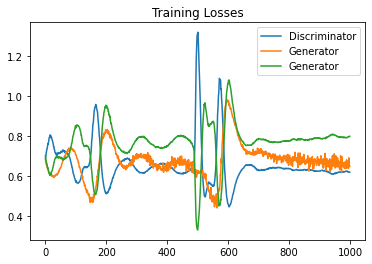

In [172]:
fig, ax = plt.subplots()

plt.plot(disc_loss_generated, label='Discriminator')
plt.plot(disc_loss_real, label='Generator')
plt.plot(combined_loss, label='Generator')

plt.title("Training Losses")
plt.legend()

In [173]:
disc_loss_generated

[0.6903183460235596,
 0.6960145831108093,
 0.7114246487617493,
 0.7184714674949646,
 0.7275226712226868,
 0.7380013465881348,
 0.7391023635864258,
 0.7522591352462769,
 0.7631333470344543,
 0.7608922123908997,
 0.7686291933059692,
 0.7767277359962463,
 0.7897311449050903,
 0.794797956943512,
 0.7963703870773315,
 0.8053499460220337,
 0.8032630085945129,
 0.8042077422142029,
 0.800866425037384,
 0.7902837991714478,
 0.7945579290390015,
 0.7856332063674927,
 0.7813962697982788,
 0.7787591218948364,
 0.7737146615982056,
 0.7634247541427612,
 0.7584545612335205,
 0.7470332384109497,
 0.7470667362213135,
 0.7337323427200317,
 0.7329599857330322,
 0.7211000919342041,
 0.7189491987228394,
 0.716293454170227,
 0.71180260181427,
 0.7158703804016113,
 0.708362877368927,
 0.7085441946983337,
 0.704096794128418,
 0.707577109336853,
 0.71531081199646,
 0.713902473449707,
 0.7118837833404541,
 0.7180322408676147,
 0.718254804611206,
 0.7164841890335083,
 0.7137466669082642,
 0.7171726226806641,
 0.7

In [174]:
num_examples_to_generate = 23000

z = np.random.normal(3,2,size=(23000, rand_dim))

fake = generator(z)


In [175]:
fake=fake.numpy()

In [176]:
fake

array([[ 3.7263246e+00, -8.4910738e-01, -6.0847484e-02, ...,
        -2.4302594e-01,  2.6557287e-02,  3.1583339e-02],
       [ 3.6391296e+00, -6.4110595e-01,  4.7925271e-02, ...,
        -1.4806728e-02,  1.2184825e-01,  6.1636925e-02],
       [ 4.1057119e+00, -8.2278639e-01,  2.6959303e-01, ...,
         4.9509328e-02,  1.6050918e-01,  1.9158065e-01],
       ...,
       [ 4.2847481e+00, -1.1281343e+00,  3.4564173e-01, ...,
        -2.7891353e-01,  1.2699531e-01, -2.8356731e-02],
       [ 3.8809142e+00, -6.0307235e-01,  1.0628739e-02, ...,
        -1.5440218e-01,  7.2239421e-02,  4.1419163e-02],
       [ 4.1297264e+00, -5.0380486e-01,  2.7031168e-01, ...,
         1.2544571e-01, -3.8201902e-03,  1.6310444e-01]], dtype=float32)

In [177]:
df = pd.DataFrame(fake,columns = ['component_1'	,'component_2',	'component_3',	'component_4',	'component_5',	'component_6',	'component_7',	'component_8',	'component_9',	'component_10'	,'component_11'	,'component_12'	,'component_13',	'component_14'])

In [178]:
df

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14
0,3.726325,-0.849107,-0.060847,-0.286779,0.059747,-0.016993,-0.173887,-0.194994,-0.161206,0.110189,-0.199345,-0.243026,0.026557,0.031583
1,3.639130,-0.641106,0.047925,0.235449,0.320914,-0.203290,-0.062467,-0.436735,0.113201,0.361681,0.193758,-0.014807,0.121848,0.061637
2,4.105712,-0.822786,0.269593,0.009626,0.365104,0.073510,0.257494,-0.612898,-0.157699,0.362615,0.056816,0.049509,0.160509,0.191581
3,4.576677,-1.247965,0.299675,-0.117431,0.292176,0.130287,0.153376,-0.764588,0.152466,0.381662,0.368758,-0.029855,0.114659,0.287289
4,4.023985,-0.564877,-0.157567,-0.224030,-0.036015,-0.035995,0.098602,-0.513747,-0.101924,0.112436,-0.025204,0.240363,-0.045828,-0.012641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22995,3.614884,-0.291609,-0.000746,0.002595,0.222796,0.168957,-0.013970,-0.539575,-0.077179,0.561142,0.131630,-0.102491,0.232366,-0.257648
22996,3.988079,-0.594534,0.138395,-0.180817,0.500363,0.167297,0.390071,-0.861789,-0.278483,0.258341,0.285974,-0.201275,0.270415,0.099763
22997,4.284748,-1.128134,0.345642,0.013742,-0.025997,-0.051098,0.533753,-0.119534,0.119579,-0.062898,0.060383,-0.278914,0.126995,-0.028357
22998,3.880914,-0.603072,0.010629,0.376608,0.202939,0.288351,0.100023,-0.978654,0.002095,0.316497,0.176346,-0.154402,0.072239,0.041419


In [181]:
df.to_csv("vanillaganndos.csv",header = True,index=False)